<a href="https://colab.research.google.com/github/makaveli10/Food-101/blob/master/resnet_food_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import keras.backend as K
from keras import regularizers
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import SGD
from keras.regularizers import l2
from keras import models
import cv2

Using TensorFlow backend.


In [0]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [3]:
get_data_extract()

--2019-03-19 19:46:42--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2019-03-19 19:46:47--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  1.77MB/s    in 72m 20s 

2019-03-19 20:59:07 (1.10 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

Dataset downloaded!
Extracting data..
food-101/
food-101/images/
food-101/images/beignets/
food-101/images/beignets/2885220.jpg
food-101/images/beignets/1814040.jpg
food-1

In [0]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

1.13.1
/device:GPU:0


In [0]:
os.listdir('food-101/images')

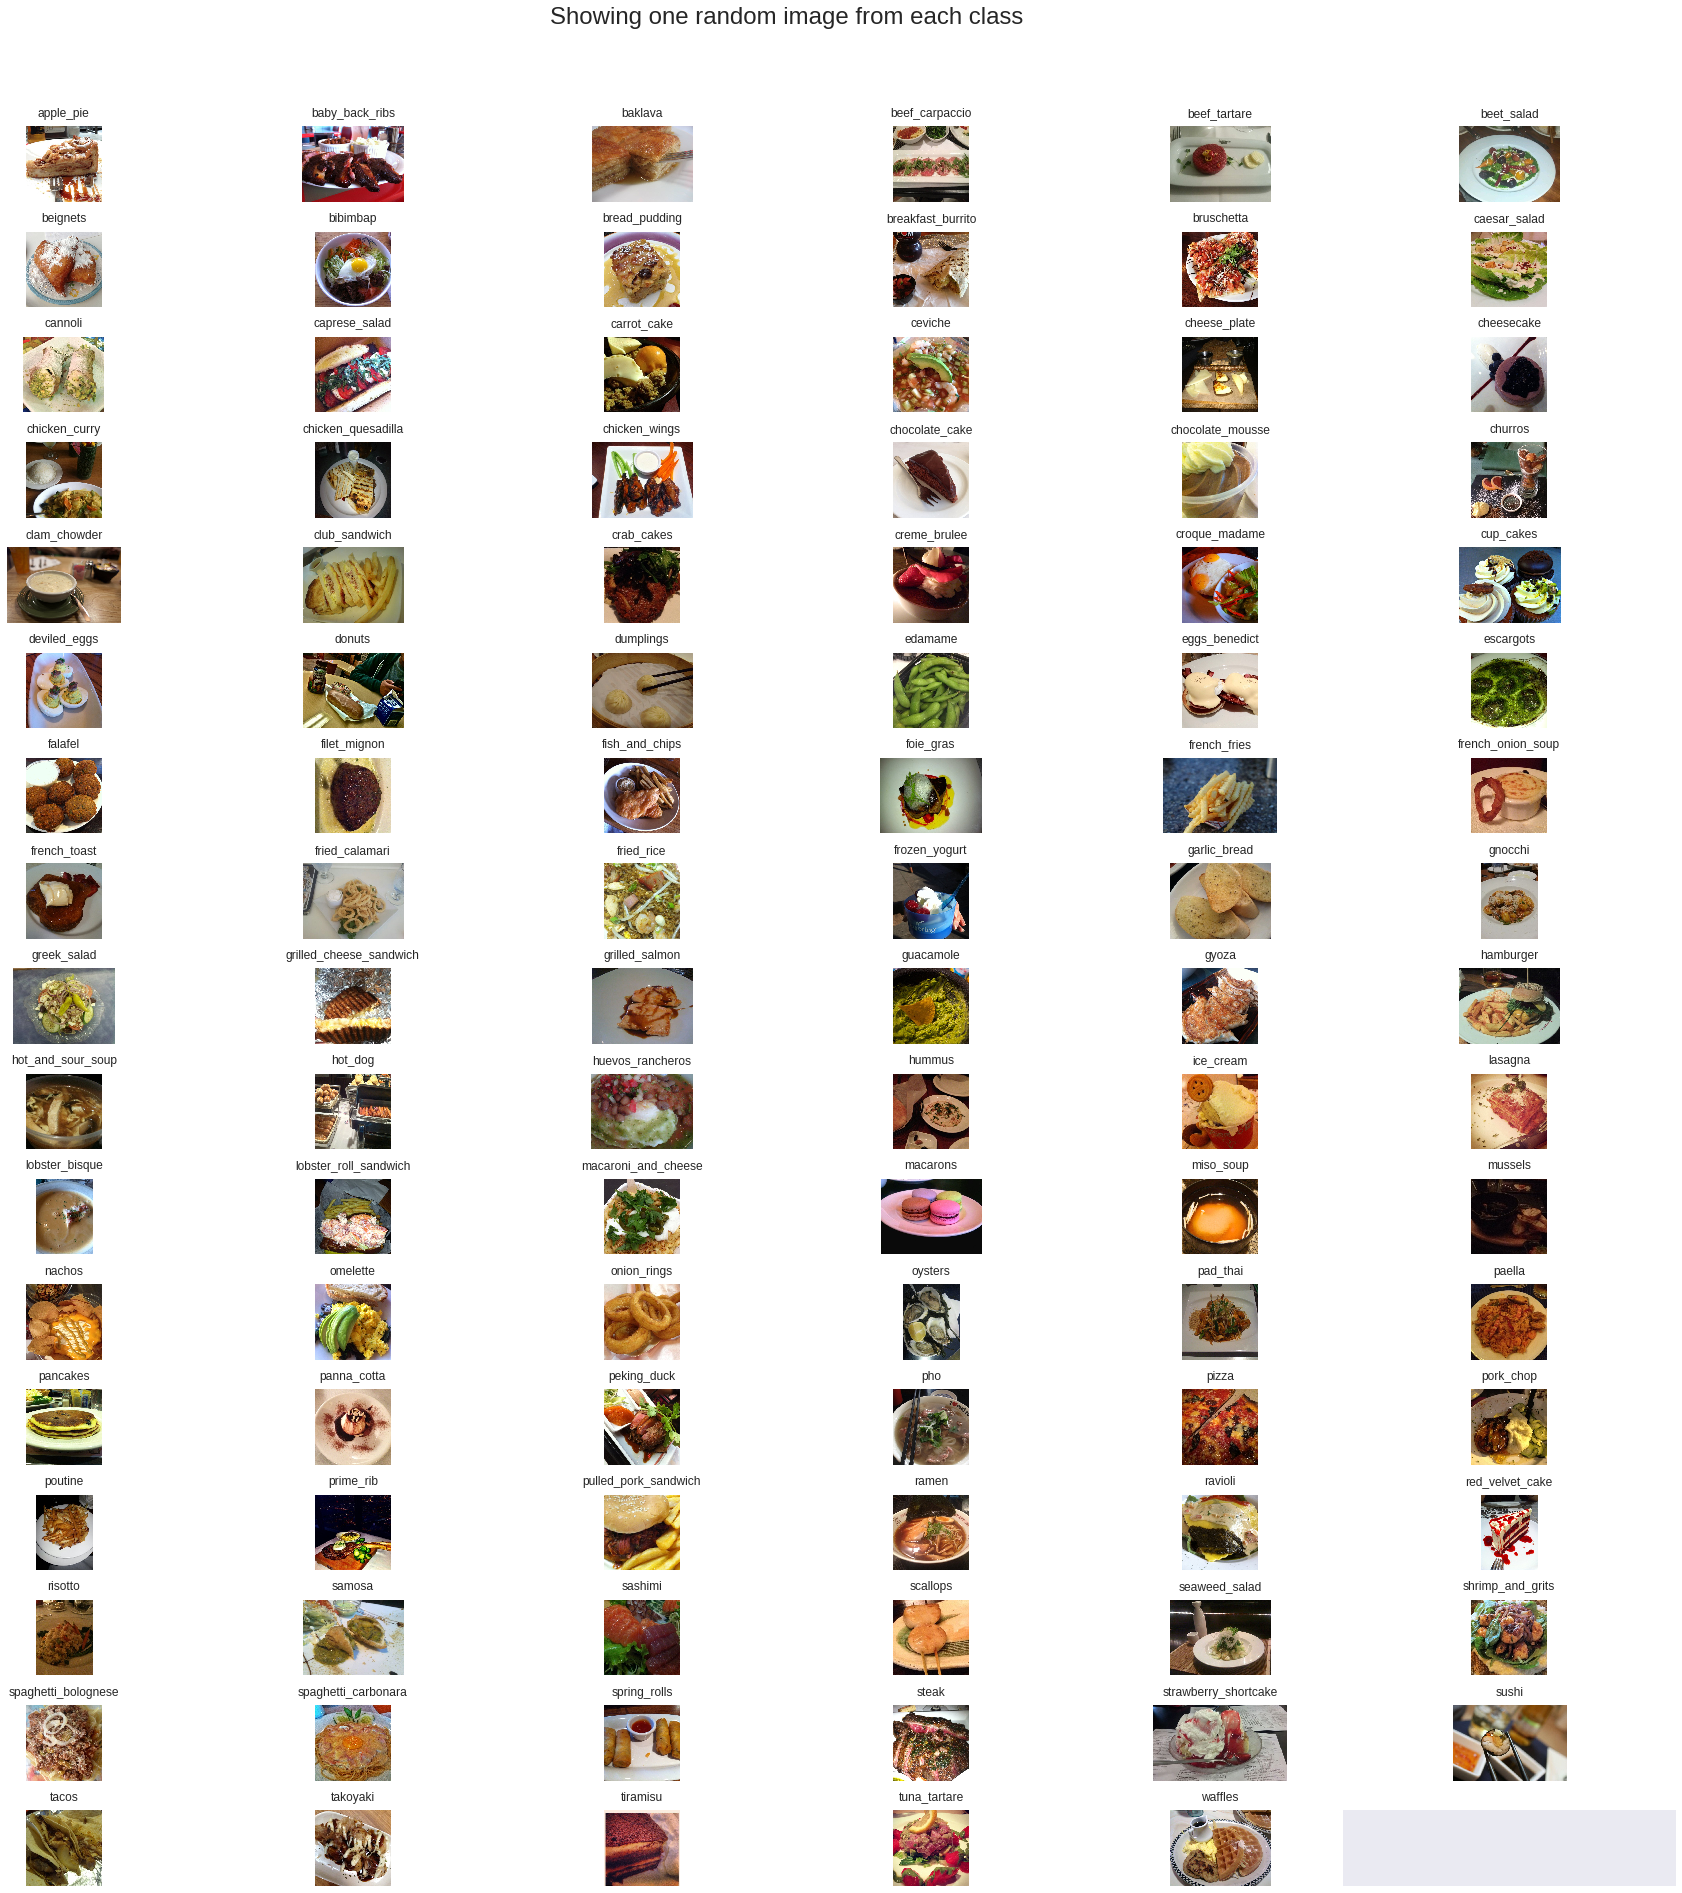

In [4]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
        
     # returns the list of all files present in each food category

    food_selected_images = os.listdir(os.path.join(data_dir,food_selected))      # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images)                # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [0]:
# Helper method to split dataset on the basis of given info
def split_data(filepath, source, dest):
  classes_img = defaultdict(list)
  with open(filepath, 'r') as txt:
    paths = [read.strip() for read in txt.readlines()]
    for path in paths:
      food_class = path.split('/')
      classes_img[food_class[0]].append(food_class[1] + '.jpg')
      
    for food in classes_img.keys():
      print("\nCopying images into ",food)
      if not os.path.exists(os.path.join(dest,food)):
        os.makedirs(os.path.join(dest,food))
      for i in classes_img[food]:
        copy(os.path.join(source,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [6]:
print("Preparing training data...")
split_data('food-101/meta/train.txt', 'food-101/images', 'train')

Preparing training data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copyin

In [7]:
print("Preparing test data...")
split_data('food-101/meta/test.txt', 'food-101/images', 'test')

Preparing test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [0]:
foods_sorted[0]

'apple_pie'

In [0]:
!ls

food-101  food-101.tar.gz  sample_data	test  train


In [0]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [0]:
def mini_dataset(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [0]:
food_list = ['apple_pie','pizza','omelette', 'sushi']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [0]:
print("Creating mini train data folder with new classes")
mini_dataset(food_list, src_train, dest_train)

Creating mini train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into sushi


In [0]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c


Total number of samples in train folder
3000


In [0]:
print("Creating mini test data folder with new classes")
mini_dataset(food_list, src_test, dest_test)


Creating mini test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into sushi


In [0]:
print("Total number of samples in test folder")

!find test_mini -type d -or -type f -printf '.' | wc -c


Total number of samples in test folder
1000


In [0]:
K.clear_session()
n_classes = 4
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 3000 #75750
nb_validation_samples = 1000 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


resnet = ResNet50(weights='imagenet', include_top=False)
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(4,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')


Found 3000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
187/187 [==============================] - 183s 979ms/step - loss: 1.2848 - acc: 0.4315 - val_loss: 0.9420 - val_acc: 0.6754

Epoch 00001: val_loss improved from inf to 0.94198, saving model to best_model_3class.hdf5
Epoch 2/30
187/187 [==============================] - 169s 906ms/step - loss: 0.9655 - acc: 0.6407 - val_loss: 0.6741 - val_acc: 0.7978

Epoch 00002: val_loss improved from 0.94198 to 0.67406, saving model to best_model_3class.hdf5
Epoch 3/30
187/187 [==============================] - 166s 889ms/step - loss: 0.7414 - acc: 0.7644 - val_loss: 0.5285 - val_acc: 0.8283

Epoch 00003: val_loss improved from 0.67406 to 0.52849, saving model to best_model_3class.hdf5
Epoch 4/30
187/187 [==============================] - 166s 887ms/step - loss: 0.

In [0]:
K.clear_session()
n_classes = 101
img_width, img_height = 299, 299
train_data_dir = 'train'
validation_data_dir = 'test'
nb_train_samples = 75750
nb_validation_samples = 25250
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


resnet = ResNet50(weights='imagenet', include_top=False)
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.4)(x)

predictions = Dense(101,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=50,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2367/2367 [==============================] - 3922s 2s/step - loss: 5.1999 - acc: 0.0663 - val_loss: 4.4047 - val_acc: 0.2422

Epoch 00001: val_loss improved from inf to 4.40468, saving model to best_model_3class.hdf5
Epoch 2/50
2367/2367 [==============================] - 3896s 2s/step - loss: 4.1505 - acc: 0.2432 - val_loss: 3.0947 - val_acc: 0.4663

Epoch 00002: val_loss improved from 4.40468 to 3.09468, saving model to best_model_3class.hdf5
Epoch 3/50
2367/2367 [==============================] - 3915s 2s/step - loss: 3.3507 - acc: 0.3804 - val_loss: 2.5134 - val_acc: 0.5779

Epoch 00003: val_loss improved from 3.09468 to 2.51337, saving model to best_model_3class.hdf5
Epoch 4/50
2367/2367 [==============================] - 3905s 2s/step - loss: 2.